In [162]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
from pandas.tseries.offsets import DateOffset

In [188]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer 

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [323]:
df = pd.read_csv("test_data (1).csv")
df.head()

,Unnamed: 0,ts,user,payment
0,534543,2022-01-01 00:03:40.907,Kkkww7LxsEqojhi6i,101.000
1,534546,2022-01-01 00:53:16.300,botxbGKkKNaXfKGiR,41.000
2,534549,2022-01-01 03:50:03.295,bQbjq4PobqAFRcTy2,58.000
3,534550,2022-01-01 06:11:30.875,SXLpG8h4PmbF4Afeg,53.000
4,534551,2022-01-01 09:11:55.582,dLh5ehuYNXQDdPJ5C,17.052


In [324]:
#df = df.sort_values(by='ts')
df = df.drop(columns = ['Unnamed: 0'])
df.ts = pd.to_datetime(df.ts)
df.ts = df.ts.dt.to_period('D').dt.to_timestamp()

In [197]:
df.head()

,ts,user,payment
2001,2022-01-01,7GCSLHGSkSB3qdN5S,38.000
98,2022-01-01,EAmoSbAXS7kT3ThSX,92.000
1779,2022-01-01,99CPbc8vmeYXcCeQT,58.000
0,2022-01-01,Kkkww7LxsEqojhi6i,101.000
2968,2022-01-01,uuc7d5qwzCNGpyrin,18.061


In [216]:
df.ts.unique()

array(['2022-01-01T00:00:00.000000000', '2022-02-01T00:00:00.000000000',
       '2022-03-01T00:00:00.000000000', '2022-04-01T00:00:00.000000000',
       '2022-05-01T00:00:00.000000000', '2022-06-01T00:00:00.000000000',
       '2022-07-01T00:00:00.000000000', '2022-08-01T00:00:00.000000000',
       '2022-09-01T00:00:00.000000000', '2022-10-01T00:00:00.000000000',
       '2022-11-01T00:00:00.000000000', '2022-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [238]:
df.groupby(['user', 'ts'], as_index = False).agg({'payment':'count'})['payment'].value_counts()

1    27455
2     2843
3      392
4       95
5       22
6        8
7        4
9        2
8        2
Name: payment, dtype: int64

Покупки совершались только в 1 день месяца, при этом количество покупок у пользователя за день могло быть разным. Будем рассматривать для каждого пользователя сумму всех покупок за день.

In [325]:
df['payment_d'] = df.groupby(['user', 'ts'])['payment'].transform(pd.Series.sum)
df.groupby(['user', 'ts'], as_index = False).agg({'payment_d':pd.Series.nunique})['payment_d'].value_counts()

1    30823
Name: payment_d, dtype: int64

<AxesSubplot:>

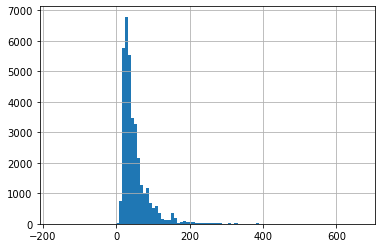

In [242]:
df['payment_d'].hist(bins = 100)

In [326]:
df = df[['ts', 'user', 'payment_d']].drop_duplicates()
df.groupby(['user', 'ts'], as_index = False).agg({'payment_d':'count'})['payment_d'].value_counts()

1    30823
Name: payment_d, dtype: int64

## Ежемесячная выручка 

In [308]:
df.groupby('ts', as_index = False).agg({'payment_d':'sum'})

,ts,payment_d
0,2022-01-01,125583.44405
1,2022-02-01,122304.74531
2,2022-03-01,135702.28475
3,2022-04-01,129630.32295
4,2022-05-01,125434.95690
5,2022-06-01,107664.00200
6,2022-07-01,86557.63950
7,2022-08-01,100957.33599
8,2022-09-01,118115.96055
9,2022-10-01,112693.25433


In [322]:
df.payment_d.sum()

1396900.1727200001

Будем предсказывать общую выручку для активных пользователей. Обучим модель на датасете, состоящем из пользователей, которые уже не являются активными (перестали платить до декабря 2022) - для них уже известна общая выручка. В качестве фичей будем использовать сумму первого платежа, когорту - дата первого платежа, количество дней-платежей, сумма последнего платежа; таргет переменная - выручка со всех платежей (текущих и будущих), т.е. LTV пользователя.

In [333]:
active_2023_users = df[df.ts == '2022-12-01'].user.unique()
active_df = df[df.user.isin(active_2023_users)]
learn_df = df[~df.user.isin(active_2023_users)]
print(active_df.shape)
print(learn_df.shape)

(11569, 3)
(19254, 3)


In [334]:
learn_df['LTV'] = learn_df.groupby('user')['payment_d'].transform(pd.Series.sum)
#y = learn_df.pop('LTV')

In [342]:
def create_features(df):
    
    df['cohort'] = df.groupby('user')['ts'].transform(pd.Series.min)
    
    df0 = df[df.ts == df.cohort][['user', 'payment_d']]
    df0 = df0.rename(columns={"payment_d": "payment_first"})
    df = df.merge(df0, how = 'inner', on = 'user')
    
    df['num_payments'] = df.groupby('user')['ts'].transform(pd.Series.argsort)
    
    enc = OrdinalEncoder()
    df['cohort']  = enc.fit_transform(np.array(df['cohort']).reshape(df.shape[0],-1))
    
    #только для активных - оставляем последний момент платежа каждого юзера
    df = df[df['ts'] == '2022-12-01']
    
    X = df[['cohort', 'payment_first', 'num_payments', 'payment_d'#,
           #'LTV'
           ]]
    return X

In [336]:
X = create_features(learn_df)
X.head()

,cohort,payment_first,num_payments,payment_d,LTV
0,0.0,101.0,0,101.000,273.293
1,0.0,101.0,1,110.293,273.293
2,0.0,101.0,2,62.000,273.293
3,0.0,79.0,0,79.000,79.000
4,0.0,58.0,0,58.000,143.683


In [339]:
X_train, X_test, y_train, y_test = train_test_split(X[['cohort', 'payment_first', 'num_payments', 'payment_d']],
                                                    X['LTV'], test_size = 0.2)

In [340]:
params_grid = {'n_estimators': [20, 50, 100, 200],
               'max_depth':[2,4,6,8],
               'min_samples_leaf': [2,3,4,5]}   

reg_rf = ensemble.RandomForestRegressor()


grid_rf = GridSearchCV(reg, param_grid = params_grid, cv = 3)
grid_rf.fit(X_train, y_train)


y_pred_rf = grid_rf.predict(X_test)
print(f'RMSE = {np.sqrt(mean_squared_error(y_pred_rf,y_test))}')

RMSE = 88.81988216473633


In [341]:
grid_rf.best_estimator_


RandomForestRegressor(max_depth=8, min_samples_leaf=2, n_estimators=200)

In [275]:
import catboost
import lightgbm
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


In [277]:
params_grid_ = {'learning_rate':[0.05, 0.1, 0.5],
               'n_estimators': [10, 20, 50, 100],
               'max_depth':[2,4,6,8],
               'alpha':[0, 0.1, 1, 5, 10],
               'lambda':[0, 0.1, 1, 5, 10]
              }   

reg_xgb = xgb.XGBRegressor(objective ='reg:linear')


grid_xgb = GridSearchCV(reg_xgb, param_grid = params_grid_, cv = 3)
grid_xgb.fit(X_train, y_train)


y_pred_xgb = grid_xgb.predict(X_test)
print(f'RMSE = {np.sqrt(mean_squared_error(y_pred_xgb,y_test))}')

[02:28:24] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[02:28:24] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[02:28:24] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[02:28:24] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[02:28:24] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscal

In [284]:
grid_xgb.best_estimator_

XGBRegressor(alpha=5, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', lambda=10, learning_rate=0.05,
             max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, ...)

С точки зрения ошибки rmse модели random forest лучше. Построим с помощью этой модели предсказание выручки для активных пользователей. Вычтем из неё все оплаты за 2022 год - в сумме получим выручку за 2023.

In [347]:
X_a = create_features(active_df)

In [348]:
X_a['LTV'] = grid_rf.predict(X_a)

ltv_2023 = X_a.LTV.sum() - active_df.payment_d.sum()

#revenue_2023 = X_a[X_a.cohort == '2022-12-01'].LTV.sum()
print(f'суммарная выручка активных в 2023: {ltv_2023}')

суммарная выручка активных в 2023: 27186.86787239759
